In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import qpulse as qp
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
import time

# sys.path.append('C:/Program Files/Labber/Script')
# import Labber

# from labber_script_extension.script_object  import ScriptObject


# Parameters

In [3]:
NUM_STEPS = 40
NUM_QUBITS = 2

# Generate Pulses

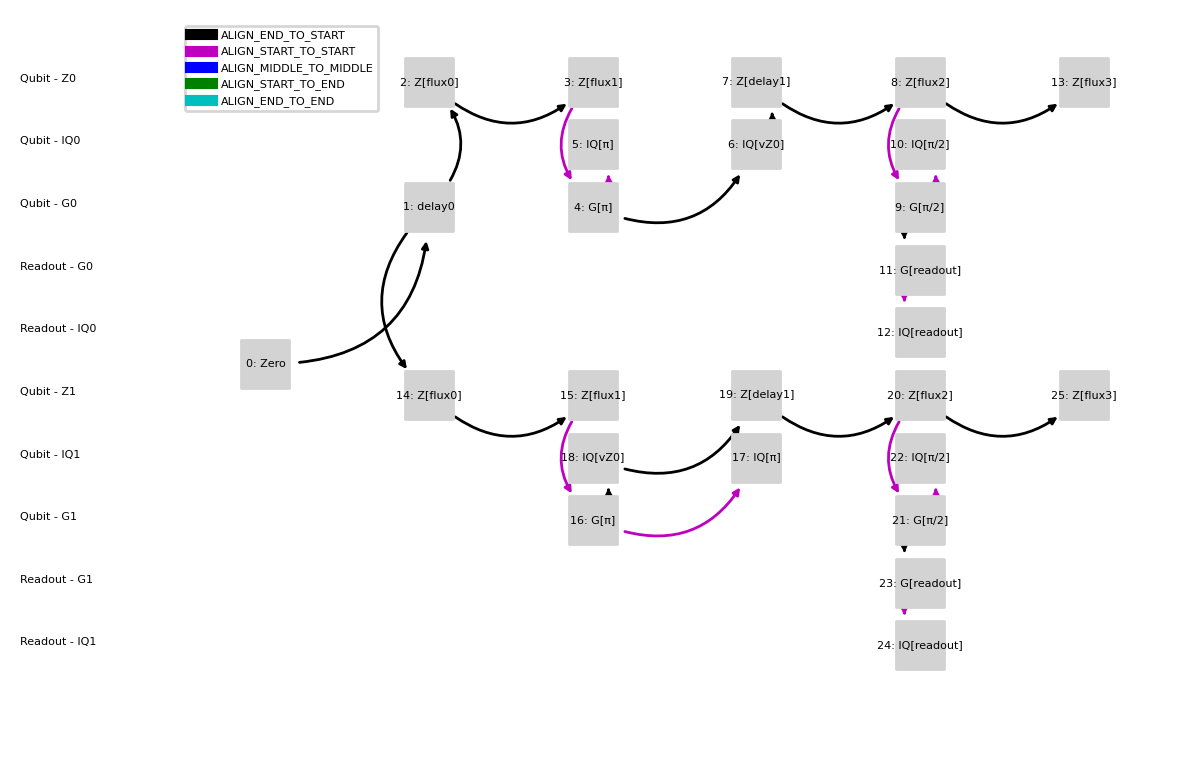

In [4]:
""" Create Pulse Graph. """
pg = qp.PulseGraph()
qsys = qp.System(pg, name="Amir's System")

for j in range(NUM_QUBITS):
    qsys.add_qubit({"f": 100.0e-3, "f_r": 50.0e-3}) # IF frequency of qubit, IF frequency of readout for qubit

qsys[0].add_raw_pulse(pg.zero, qp.zeros, "G", relationship=qp.AlignTypes.ALIGN_END_TO_START, name="delay0")


delay_pulse = qsys[0].pulses["delay0"]["G"]
for j in range(NUM_QUBITS):
    qsys[j].add_flux_pulse(delay_pulse, qp.constant, name="flux0")
    qsys[j].add_flux_pulse(qsys[j].pulses["flux0"]["Z"], qp.constant, name="flux1")
    qsys[j].add_drive_pulse(qsys[j].pulses["flux1"]["Z"], qp.sinusoidal_pulse, name="π", relationship=qp.AlignTypes.ALIGN_START_TO_START)
    qsys[j].add_virtual_z_pulse(qsys[j].pulses["π"]["G"], name="vZ0")
    
    qsys[j].add_flux_pulse(qsys[j].pulses["vZ0"]["IQ"], qp.zeros, name="delay1")

    qsys[j].add_flux_pulse(qsys[j].pulses["delay1"]["Z"], qp.constant, name="flux2")
    qsys[j].add_drive_pulse(qsys[j].pulses["flux2"]["Z"], qp.sinusoidal_pulse, name="π/2", relationship=qp.AlignTypes.ALIGN_START_TO_START)
    qsys[j].add_readout_pulse(qsys[j].pulses["π/2"]["G"], qp.constant, name="readout")
    qsys[j].add_flux_pulse(qsys[j].pulses["flux2"]["Z"], qp.constant, name="flux3")
    
qsys.draw()
# qsys[0].pulses



# Sweep

In [5]:
# TODO: create skeleton builder wrapper, as this is not super user friendly

skeleton = {}

delay1_length = qp.PulseVariable()

for j in range(NUM_QUBITS):
    skeleton[qsys[j].pulses["flux0"]["Z"].id] = {"amplitude": -1}
    skeleton[qsys[j].pulses["flux2"]["Z"].id] = {"duration":200}
    skeleton[qsys[j].pulses["vZ0"]["IQ"].id] = {"phase": np.pi/2}
    skeleton[qsys[j].pulses["flux3"]["Z"].id] = {"amplitude": -1, "duration":200}
    skeleton[qsys[j].pulses["delay1"]["Z"].id] = {"duration": delay1_length}

In [6]:
sweep_params = qsys.gen_params(skeleton=skeleton, variable_map={delay1_length.id: np.linspace(0, 240, NUM_STEPS)})
qexp = qp.Experiment(qsys, params = sweep_params, dts={})

# Plot Signals

In [7]:
_ = qexp.experiment.signals[0]

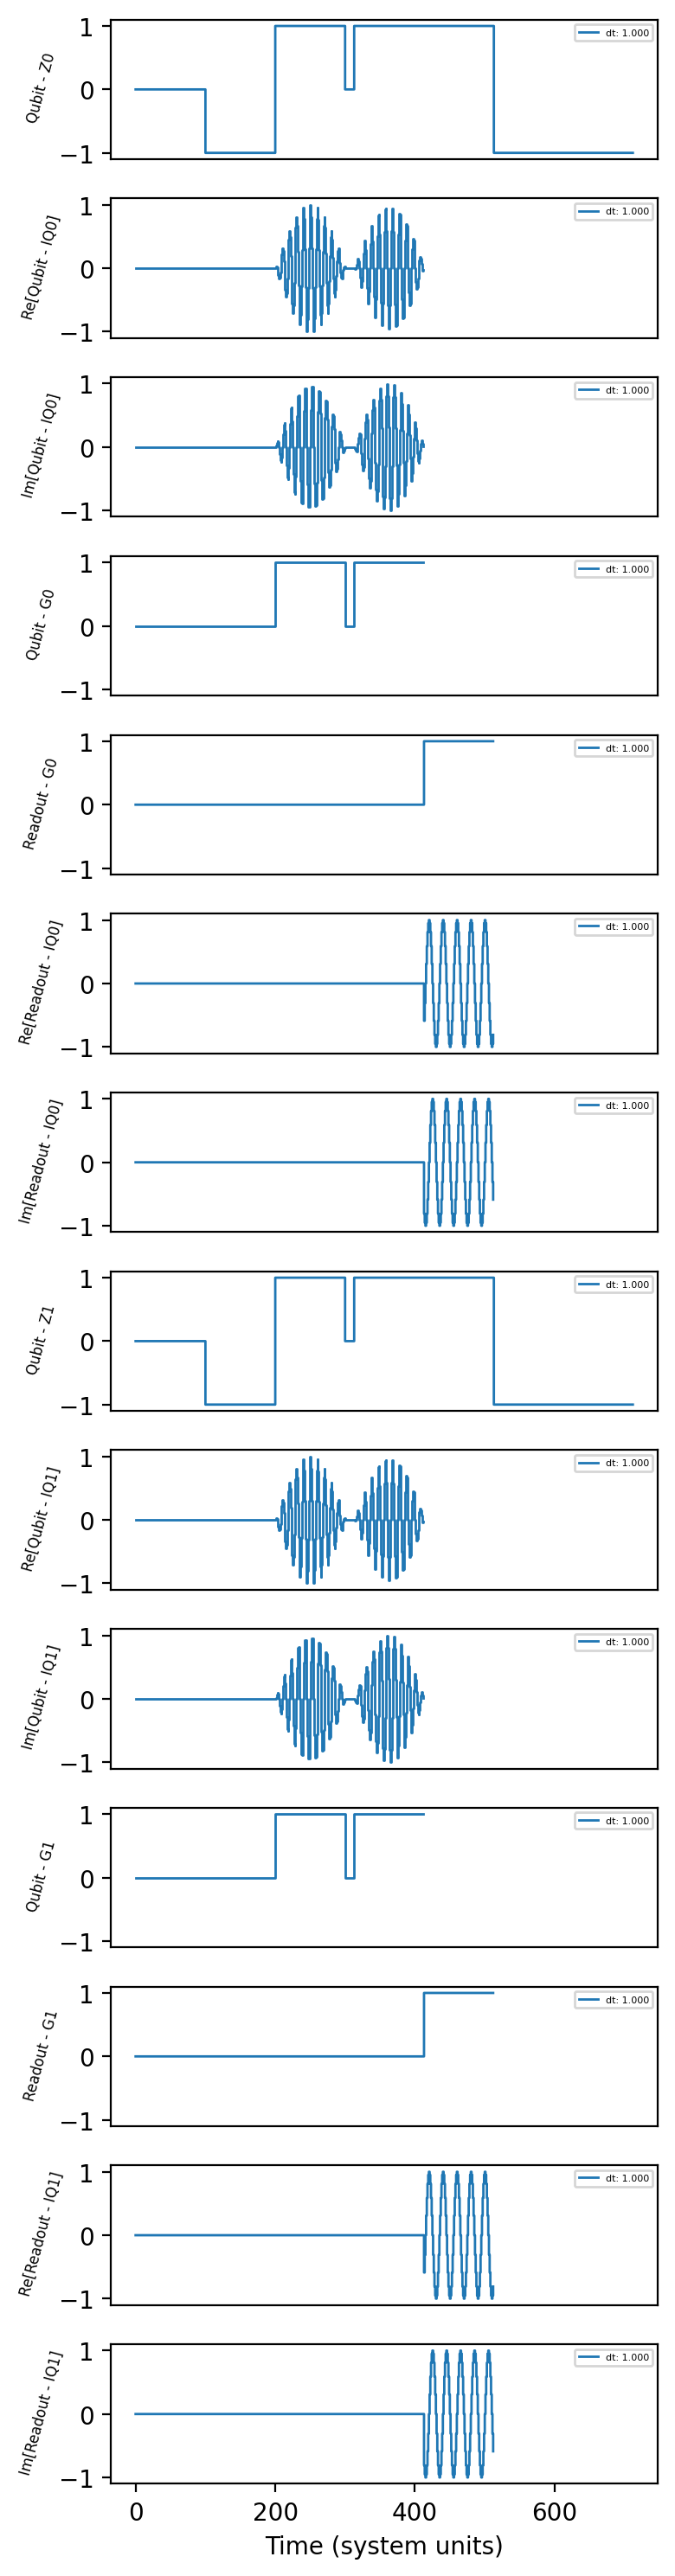

In [8]:
_ = qexp.plot(2)

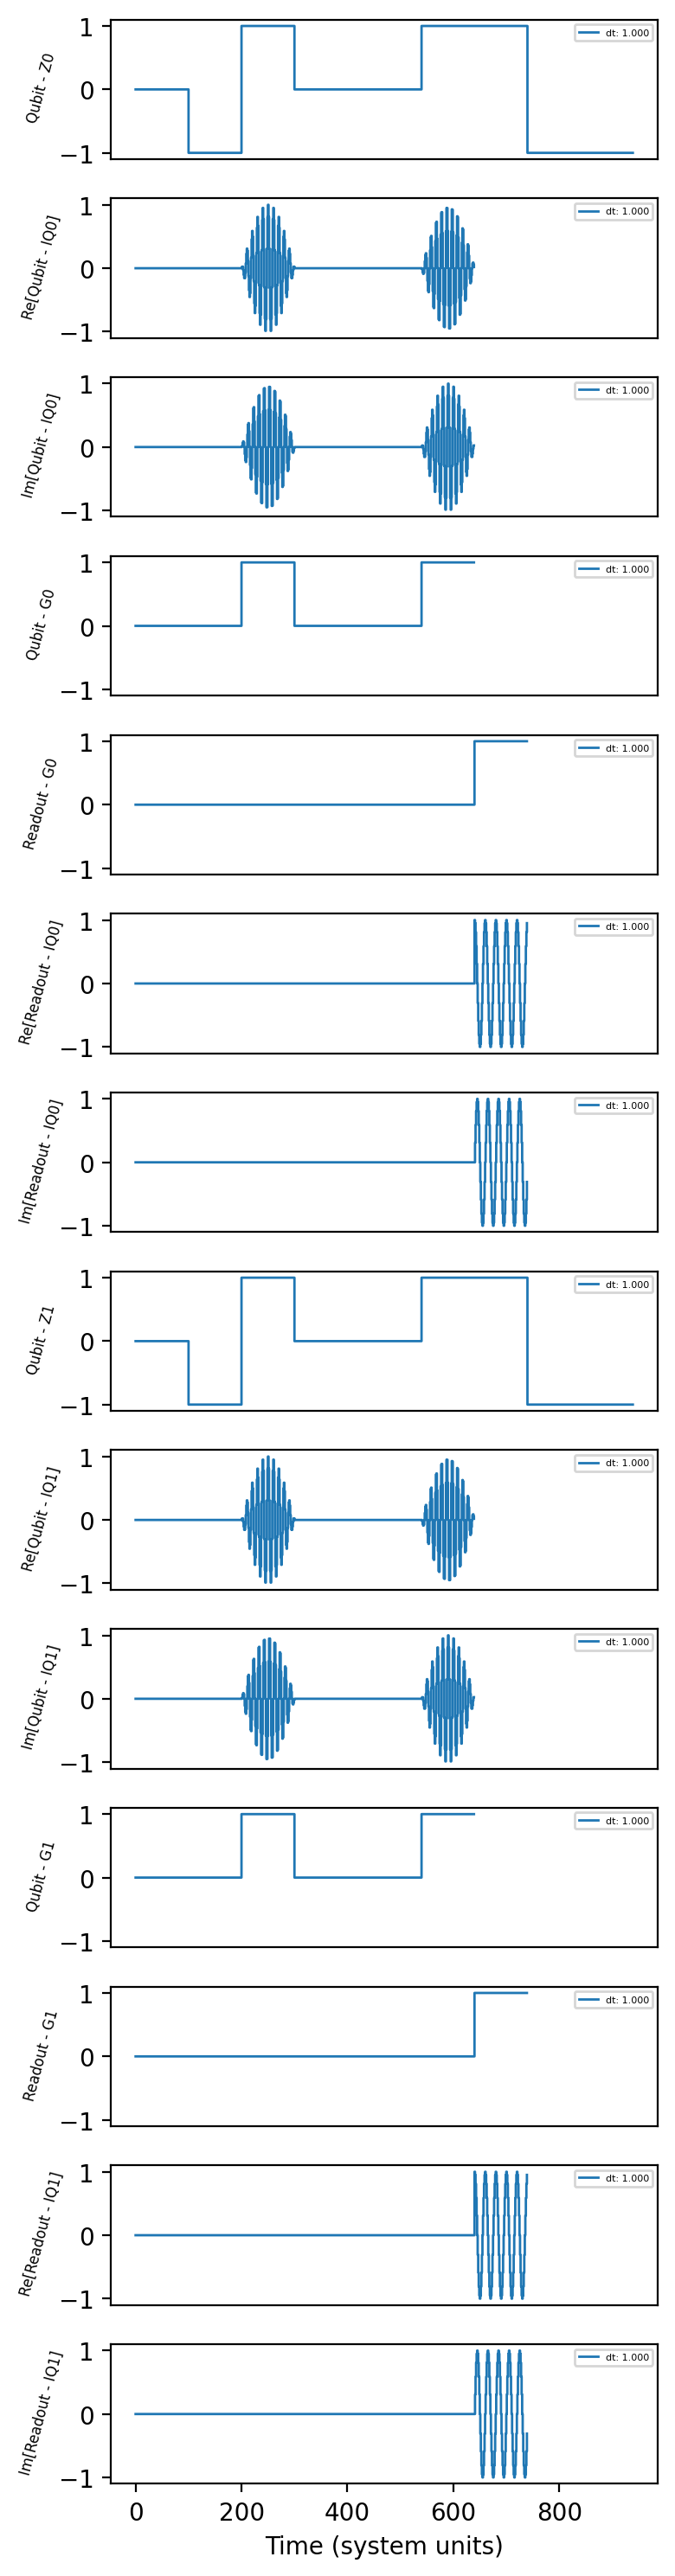

In [9]:
_ = qexp.plot(39)

# Export/Import Signals

In [10]:
virtual_to_real_channel_mapping = [
    ([f"Readout - IQ{j}" for j in range(NUM_QUBITS)], "Readout - IQ0"),
    ([f"Readout - G{j}" for j in range(NUM_QUBITS)], "Readout - G0"),
]
qexp.export_signals(filename="data.hdf5", use_channel_names=True, trim_zeros=True, virtual_to_real_channel_mapping=virtual_to_real_channel_mapping)

In [11]:
signals_hdf5 = qp.import_signals("data.hdf5")

In [12]:
signals_hdf5[0].keys()

dict_keys(['Im: Qubit - G0', 'Im: Qubit - G1', 'Im: Qubit - IQ0', 'Im: Qubit - IQ1', 'Im: Qubit - Z0', 'Im: Qubit - Z1', 'Im: Readout - G0', 'Im: Readout - IQ0', 'Re: Qubit - G0', 'Re: Qubit - G1', 'Re: Qubit - IQ0', 'Re: Qubit - IQ1', 'Re: Qubit - Z0', 'Re: Qubit - Z1', 'Re: Readout - G0', 'Re: Readout - IQ0'])